## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
data.income.value_counts() , data.shape

(<=50K    34014
 >50K     11208
 Name: income, dtype: int64,
 (45222, 14))

In [3]:
# Total number of records
n_records = data.shape[0] 

# Number of records where individual's income is more than $50,000
n_greater_50k = data.income.value_counts()[1]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.income.value_counts()[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = 100 * n_greater_50k/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

C:\Users\ashra\.ipynb\Supervised Machine Learning\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


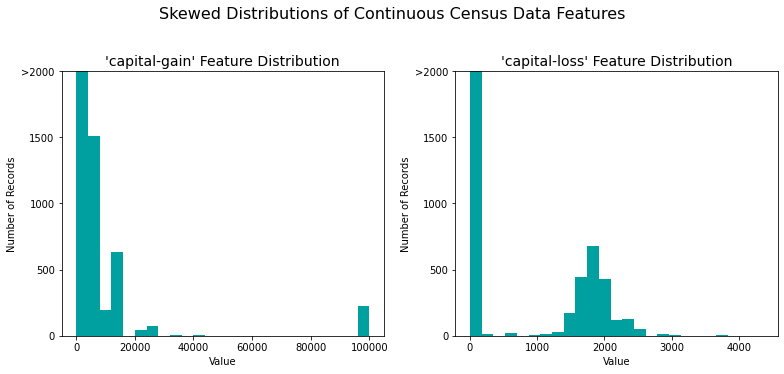

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

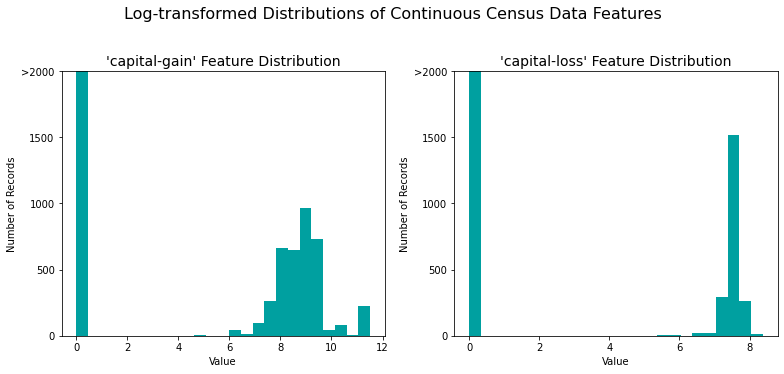

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing
.

In [21]:
#One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

#Encode the 'income_raw' data to numerical values
replace_dict = {'<=50K':0, '>50K':1} 
income = income_raw.replace(replace_dict)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [9]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace


* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [10]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = TP / income.count()
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+ 0.5**2) * (precision*recall) / ((0.5**2)*precision + recall)

# Print the results 

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html)
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

## List of Content:

#### 1.Random Forest Model.

    1.1. Application of Random Forest Model.
    1.2. Model Strengths.
    1.3. Model Weaknesses.
    1.4. Negotiation between the Algorithem and the Data.


#### 2.Support Vector Machines (SVM) Model.

    2.1. Application of SVM Model.
    2.2. Model Strengths.
    2.3. Model Weaknesses.
    2.4. Negotiation between the Algorithem and the Data.
    
    
#### 3.Stochastic Gradient Descent Classifier (SGDC) Model.

    2.1. Application of SGDC Model.
    2.2. Model Strengths.
    2.3. Model Weaknesses.
    2.4. Negotiation between the Algorithem and the Data.

## 1.Random Forest Model.

#### 1.1. Application of Random Forest Model :

    Financial, Medical sectors and remotely-sensed imagery classification.



#### 1.2. Model Strengths :

   * Accuracy of Random forest is generally very high
   * Its efficiency is particularly Notable in Large Data sets
   * Provides an estimate of important variables in classification
   * Forests Generated can be saved and reused
   * Unlike other models It does nt overfit with more features


#### 1.3. Model Weaknesses :

   * It requires much computational power as well as resources as it builds numerous trees to combine their outputs. 
   * It also requires much time for training as it combines a lot of decision trees to determine the class.
   * Due to the ensemble of decision trees, it also suffers interpretability and fails to determine the significance of each variable.
   
   
#### 1.4. Negotiation between the Algorithem and the Data :

   * It's a financial Problem so we need a high accuracy model to predict our income.
   * we have alot of data so this kind of algorithems work extremly good with.
   * we have alot of variables and this model can ignore overfit very well.
   

## 2. Support Vector Machines (SVM) Model.

#### 1.1. Application of SVM Model :

* text and hypertext categorization
* Classification of images
* Hand-Written recognition.


#### 1.2. Model Strengths :

* SVM works relatively well when there is a clear margin of separation between classes.
* SVM is more effective in high dimensional spaces.
* SVM is effective in cases where the number of dimensions is greater than the number of samples.
* SVM is relatively memory efficient

#### 1.3. Model Weaknesses :

* SVM algorithm is not suitable for large data sets.
* SVM does not perform very well when the data set has more noise i.e. target classes are overlapping.
* In cases where the number of features for each data point exceeds the number of training data samples, the SVM will underperform.
* As the support vector classifier works by putting data points, above and below the classifying hyperplane there is no * * probabilistic explanation for the classification.
   
   
#### 1.4. Negotiation between the Algorithem and the Data :

* SVM Works well with large features.
* Have enough Data samples to train.
* Not very Big Data we're dealing with.

## 3. Stochastic Gradient Descent Classifier (SGDC) Model.

#### 1.1. Application of SGDC Model :


    Classification of images


#### 1.2. Model Strengths :

* It is easier to fit in the memory due to a single training example being processed by the network.
* It is computationally fast as only one sample is processed at a time.
* For larger datasets, it can converge faster as it causes updates to the parameters more frequently.
* Due to frequent updates, the steps taken towards the minima of the loss function have oscillations that can help to get out of the local minimums of the loss function (in case the computed position turns out to be the local minimum).

#### 1.3. Model Weaknesses :

* Due to frequent updates, the steps taken towards the minima are very noisy. This can often lean the gradient descent into other directions.
* Also, due to noisy steps, it may take longer to achieve convergence to the minima of the loss function.
* Frequent updates are computationally expensive because of using all resources for processing one training sample at a time.
* It loses the advantage of vectorized operations as it deals with only a single example at a time.
   
   
#### 1.4. Negotiation between the Algorithem and the Data :

* works well with labeled data.
* Have enough Data samples to train.
* Not very Big Data we're dealing with.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit()
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.
SGDClassifier trained on 36177 samples.


C:\Users\ashra\.ipynb\Supervised Machine Learning\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


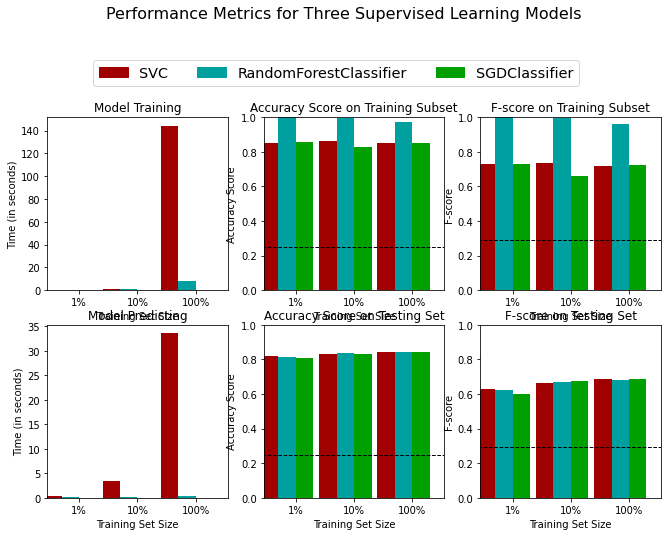

In [12]:
# Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# Initialize the three models
clf_A = SVC(random_state = 1)
clf_B = RandomForestClassifier(random_state = 1)
clf_C = SGDClassifier(random_state = 1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(samples_100 / 10)
samples_1 = int(samples_100 / 100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [13]:
results

{'SVC': {0: {'train_time': 0.025360822677612305,
   'pred_time': 0.46393561363220215,
   'acc_train': 0.8533333333333334,
   'acc_test': 0.8180210060807076,
   'f_train': 0.732758620689655,
   'f_test': 0.6277580071174378},
  1: {'train_time': 0.880587100982666,
   'pred_time': 3.449514389038086,
   'acc_train': 0.86,
   'acc_test': 0.8316196793808734,
   'f_train': 0.7352941176470589,
   'f_test': 0.662986635676932},
  2: {'train_time': 144.48668909072876,
   'pred_time': 33.62581157684326,
   'acc_train': 0.8533333333333334,
   'acc_test': 0.8423438363736871,
   'f_train': 0.7169117647058826,
   'f_test': 0.685054319164645}},
 'RandomForestClassifier': {0: {'train_time': 0.22492432594299316,
   'pred_time': 0.18692302703857422,
   'acc_train': 1.0,
   'acc_test': 0.8155887230514096,
   'f_train': 1.0,
   'f_test': 0.621124768845861},
  1: {'train_time': 0.653033971786499,
   'pred_time': 0.24988055229187012,
   'acc_train': 0.9966666666666667,
   'acc_test': 0.8365948037589829,
   'f

----
## Improving Results

#### Choosing the Best Model Based on:

* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

#### both RandomForestClassifier and SGDClassifier have good fscore and accuracy in testing data but there's big differnce fscore&accuracy between trainning and testing data in the Random Forest and that may lead to overfitting, So I suggest SGDC Model.

### Describing the Model in Layman's Terms


#### Dear CharityML,

First of all, I'm pleased to work in this project. It was a challenging project, so now I'll describe the process we did to make our predictor model.

We had made some analysis and visualization to better understand our data. then transform the numeric data to get better range, and made some transformation in the categorical date, furthermore we did split our data to trainning data and testing data to know the best model between the reccommended models we had chosen.

We got that SGDC Model the best one for our data because it had got the best accurracy - in the tranning and testing set - to predict the people who has more than 50K income. and the time consumption was good enough.

### Implementation: Model Tuning

In [17]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# Initialize the classifier
clf = SGDClassifier(random_state = 1)

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'penalty': ['l2', 'l1'],
             'alpha': [.0001,.0003,.0005,.001,.005,.01,.015,0.1]}
# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters,scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8407
F-score on testing data: 0.6879

Optimized Model
------
Final accuracy score on the testing data: 0.8412
Final F-score on the testing data: 0.6832


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |    83.97 %        |    84.09 %      |
| F-score        |    67.86 %        |    68.73 %      |


**The Optimized Model is better from the unoptimized model by almost 1% in F-score metric test (that means the optimized model can predict more true positives) and that's our goal to perfom a model has a good F-score (0.5 beta). Also the accurracy metric test is a little better in the optimized model.**

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### The Five Features that has higher correlation to the predictor income in my opinion:

  1. **Age**: Because the older you're the higher probability to have high position in companies.
    
    
  2. **Educational Level**: Because the more eduactional you take the more Responsibility you have towards society.
    
    
  3. **Occupation**: Because the hour salary for one who graduated from Engineering Faculty in usa not as like as one who                  graduated from Social Service Faculty in Egypt.
    
    
  4. **Hours-per-week**: Because the more you work the more you gain.
    
    
  5. **Capital Gain**: the more capital you gain the more capital you have.

### Implementation - Extracting Feature Importance`.

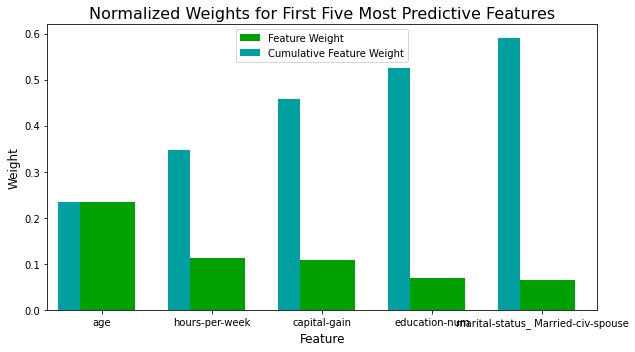

In [18]:

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier(random_state=1).fit(X_train,y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
import matplotlib.pyplot as plt

vs.feature_plot(importances, X_train, y_train)


### Question - Extracting Feature Importance


--------------------------------

**Answer**
* The feature importance predict the best five feature is (age, hours per week, capital-gain,    marital-status, relationship)
* But we Predict (age, educational level, occupation, hours per week, capital gain)
* So we have 3 right gusses (age, hours per week, capital gain) and thats because of this three is effecting directly the income money.
* But the data is saying the status of your heart is effecting your money and its a little              surprising :")
    
    

### Feature Selection


In [19]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8412
F-score on testing data: 0.6832

Final Model trained on reduced data
------
Accuracy on testing data: 0.8278
F-score on testing data: 0.6504


### Effects of Feature Selection

-----------------------

**Results :**

|     Metric     | Full Data Model | Reduced Features Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |    84.09 %        |    80.25 %      |
| F-score        |    68.73 %        |    56.22 %      |


1. The full data is better for predicting as we can see in the accuracy Score and F-Score.
2. If time is a factor I'd reccommend to change the the model Algorithem not the features because all the features is important in some level.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [20]:
!!jupyter nbconvert *.ipynb

['Traceback (most recent call last):',
 '  File "c:\\users\\ashra\\appdata\\local\\programs\\python\\python39\\lib\\runpy.py", line 197, in _run_module_as_main',
 '    return _run_code(code, main_globals, None,',
 '  File "c:\\users\\ashra\\appdata\\local\\programs\\python\\python39\\lib\\runpy.py", line 87, in _run_code',
 '    exec(code, run_globals)',
 '  File "C:\\Users\\ashra\\AppData\\Local\\Programs\\Python\\Python39\\Scripts\\jupyter-nbconvert.EXE\\__main__.py", line 7, in <module>',
 '  File "c:\\users\\ashra\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\jupyter_core\\application.py", line 254, in launch_instance',
 '    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)',
 '  File "c:\\users\\ashra\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\traitlets\\config\\application.py", line 845, in launch_instance',
 '    app.start()',
 '  File "c:\\users\\ashra\\appdata\\local\\programs\\python\\python39\\lib\\site-packages\\nbc